In [26]:
%load_ext autoreload
%autoreload 2
from text3d2video.artifacts.animation_artifact import AnimationArtifact
import torch

from text3d2video.ipython_utils import display_ims
import torchvision.transforms.functional as TF
from einops import rearrange
from text3d2video.rendering import make_feature_renderer
from pytorch3d.renderer import TexturesVertex

anim = AnimationArtifact.from_wandb_artifact_tag("backflip:latest")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


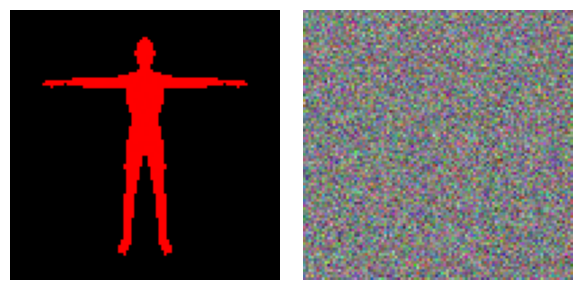

In [27]:
mesh = anim.load_unposed_mesh()
camera = anim.camera(1)

# initialize red feature texture
mesh_features = torch.zeros(1, mesh.num_verts_per_mesh()[0], 3).cuda()
mesh_features[:, :, 0] = 1.0
tex = TexturesVertex(mesh_features)
mesh.textures = tex

# render the feature image
renderer = make_feature_renderer(camera, 100)
rendered_features = renderer(mesh)

# initialize random original feature
original_features = torch.randn_like(rendered_features)
original_features = (original_features - original_features.min()) / (
    original_features.max() - original_features.min()
)

rendered_features = rearrange(rendered_features, "b h w c -> b c h w")
original_features = rearrange(original_features, "b h w c -> b c h w")

display_ims(
    [TF.to_pil_image(fmap[0]) for fmap in [rendered_features, original_features]],
    scale=3,
)

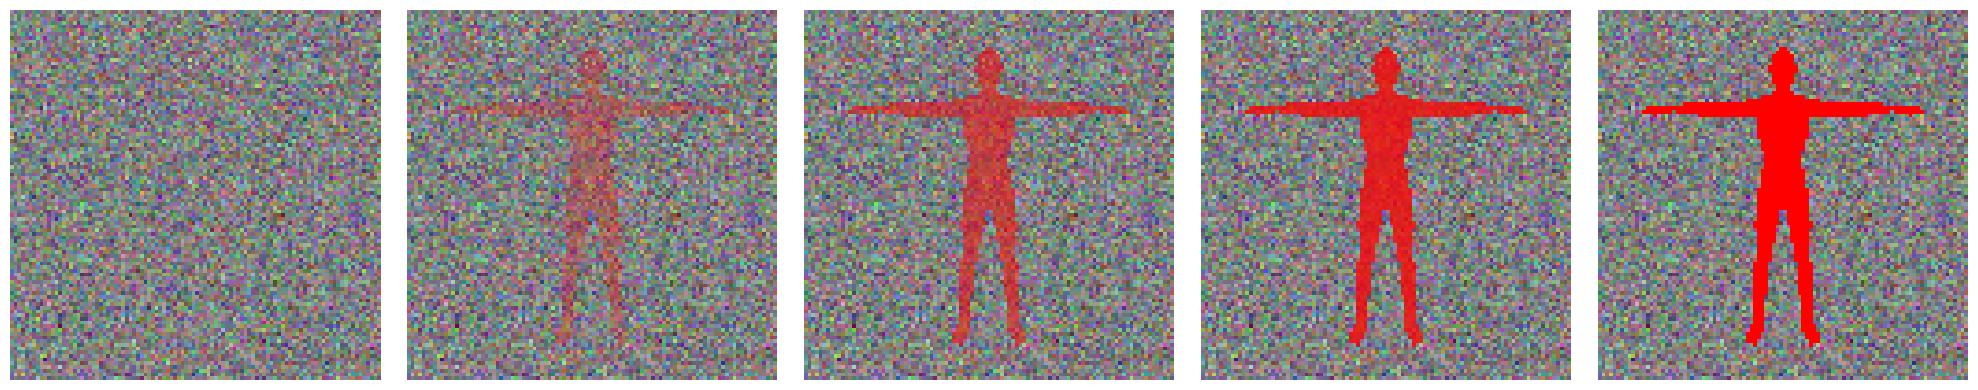

In [28]:
from text3d2video.util import blend_features

n_alphas = 5
blended_ims = [
    blend_features(original_features, rendered_features, alpha, channel_dim=1)
    for alpha in torch.linspace(0, 1, n_alphas)
]

display_ims([TF.to_pil_image(blended[0]) for blended in blended_ims], scale=4)

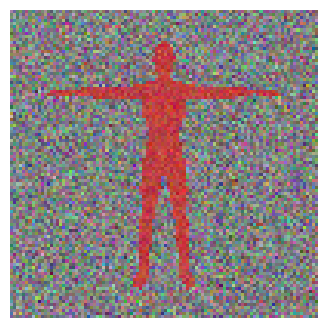

<Figure size 640x480 with 0 Axes>

In [32]:
original_double_batch = original_features.unsqueeze(0)
rendered_double_batch = rendered_features.unsqueeze(0)

blended_double_batch = blend_features(
    original_double_batch, rendered_double_batch, 0.5, channel_dim=2
)

blended_double_batch.shape
display_ims([TF.to_pil_image(blended_double_batch[0, 0])], scale=4)